In [72]:
import os
import arrow
import sys
import pytz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import chinese_calendar as calendar

from yoda import datetime as datetime_utils
from datetime import datetime
from pymongo import MongoClient
from tensorflow.python.keras.layers import Input, Dense, concatenate, Dropout
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib.font_manager import FontManager, FontProperties

# 设置全局字体为中文字体
font_path = '/System/Library/Fonts/STHeiti Light.ttc'
font_prop = FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

In [1]:
# 默认城市编码，深圳市
DEFAULT_CITY_CODE = '440300'

In [13]:
client = MongoClient('192.168.10.134', 27003)
db = client['aoao-plus-predict']

def is_holiday(date):
    """
    判断是否是节假日
    """
    return calendar.is_holiday(date)

def compute_typhoon_flag(df: pd.DataFrame, typhoon_before_hour: int = 4, typhoon_after_hour: int = 4):
    """
    计算台风标识
    1: '无台风',
    2: f'台风前{typhoon_before_hour}小时内',
    3: '台风中',
    4: f'台风后{typhoon_after_hour}小时内'
    """
    # 深圳近期台风时间
    # UTC时间：2023-09-01 09:00:00 ~ 2023-09-03 03:00:00，注意两次台风间隔时间不能小于参数中最大间隔时间！！！
    typhoon_date_list = [
        {
            "start_at": "2023-09-01 09:00:00",
            "end_at": "2023-09-03 15:00:00",
        },
    ]
    no_typhoon = 1
    before_typhoon = 2
    typhoon = 3
    after_typhoon = 4
    df['typhoon'] = no_typhoon
    for typhoon_date in typhoon_date_list:
        start_at = typhoon_date['start_at']
        end_at = typhoon_date['end_at']
        # 标记台风中
        start_at = datetime_utils.parse_utc_from_str(start_at, 'UTC', fmt='YYYY-MM-DD HH:mm:ss').datetime
        end_at = datetime_utils.parse_utc_from_str(end_at, 'UTC', fmt='YYYY-MM-DD HH:mm:ss').datetime
        df['typhoon'] = df['typhoon'].mask(
            (df['date'] >= start_at) & (df['date'] <= end_at), typhoon
        )
        # 标记台风前
        typhoon_before_at = start_at - datetime_utils.timedelta(hours=typhoon_before_hour)
        df['typhoon'] = df['typhoon'].mask(
            (df['date'] >= typhoon_before_at) & (df['date'] < start_at), before_typhoon
        )
        # 标记台风后
        typhoon_after_at = end_at + datetime_utils.timedelta(hours=typhoon_after_hour)
        df['typhoon'] = df['typhoon'].mask(
            (df['date'] > end_at) & (df['date'] <= typhoon_after_at), after_typhoon
        )
        return df

def _process_weather_rows(rows):
    for row in rows:
        doc = {
            'city_code': row['city_code'],
            'city_name': row['city_name'],
            'date': row['date'],
            'day': row['day'],
            'hour': row['hour'],
        }
        doc.update(row['data'])
        yield doc

def load_weather_df(city_code: str = None, start_date: int = None, end_date: int = None):
    """
    按城市读取天气数据
    """
    spec = {}
    if city_code:
        spec['city_code'] = str(city_code)
    if start_date or end_date:
        spec['day'] = {}
        if start_date:
            spec['day']['$gte'] = start_date
        if end_date:
            spec['day']['$lte'] = end_date
    collection = db.weather.hourly
    records = collection.find(spec)
    df = pd.DataFrame(_process_weather_rows(records))
    if df.index.size == 0:
        raise RuntimeError('No city weather data found.')
    # 日期
    df['date'] = pd.to_datetime(df['date'], utc=True, errors='ignore')
    # 星期
    df['week'] = df['datetime'].dt.weekday + 1
    # 是否节假日
    df['is_holiday'] = df['datetime'].apply(is_holiday).astype(int)
    # 台风标识
    df = compute_typhoon_flag(df)
    return df

def load_process_weather_df(*args, **kwargs):
    """
    加载并处理天气数据、数据缺失值处理
    """
    city_code = kwargs.get('city_code')
    start_date = kwargs.get('start_date')
    end_date = kwargs.get('end_date')
    df = load_weather_df(city_code, start_date, end_date)
    if df.index.size == 0:
        raise ValueError('No weather data found.')
    df = df.rename(columns={
        "day": "日期",
        "hour": "小时",
        "temp": "温度",
        "feelslike": "体感温度",
        "dew": "露点温度",
        "humidity": "潮湿",
        "precip": "降雨",
        "precipprob": "降雨概率",
        "preciptype": "降雨类型",
        "snow": "降雪",
        "snowdepth": "降雪深度",
        "windgust": "阵风",
        "windspeed": "风速",
        "typhoon": "台风",
        "winddir": "风向",
        "sealevelpressure": "海平面气压",
        "cloudcover": "云量",
        "visibility": "能见度",
        "solarradiation": "太阳辐射",
        "solarenergy": "太阳能",
        "uvindex": "紫外线指数",
        "severerisk": "严重风险",
        "conditions": "天气",
        "week": "星期",
        "is_holiday": "是否节假日",
    })
    return df

weather_df = load_process_weather_df(city_code=DEFAULT_CITY_CODE)
columns = ['日期', '小时', '星期', '是否节假日', '温度', '体感温度', '降雨', '风速', '台风', '能见度']
weather_df = weather_df[columns]
weather_df

,日期,小时,星期,是否节假日,温度,体感温度,降雨,风速,台风,能见度
0,20230731,8,1,0,29.0,35.3,0.000,9.7,1,10.0
1,20230731,9,1,0,28.6,33.9,0.000,11.2,1,10.0
2,20230731,10,1,0,26.7,30.2,0.506,3.8,1,23.9
3,20230731,11,1,0,27.6,32.4,0.000,13.8,1,10.0
4,20230731,12,1,0,27.6,32.1,0.000,9.3,1,9.6
...,...,...,...,...,...,...,...,...,...,...
1459,20230930,3,5,1,27.0,28.1,0.000,15.6,1,24.1
1460,20230930,4,5,1,26.0,26.0,0.000,16.9,1,24.1
1461,20230930,5,5,1,25.7,25.7,0.000,16.4,1,24.1
1462,20230930,6,5,1,25.4,25.4,0.000,16.0,1,24.1


In [7]:
def load_order_df_from_csv(file_path: str):
    """
    从csv文件加载订单数据
    """
    dtype = {
        'city_code': str,
    }
    df = pd.read_csv(file_path,
                     dtype=dtype,
                     parse_dates=['created_at', 'confirmed_at', 'accepted_at', 'arrived_at', 'pickup_at',
                                  'done_at'])
    print(f'Total {df.index.size} order records loaded.')
    return df

def load_process_order_df(order_path):
    """
    加载并处理订单数据
    """
    df = load_order_df_from_csv(order_path)
    if df.index.size == 0:
        raise ValueError('No order data found.')

    # 日期处理
    date_field = 'accepted_at'
    df['date'] = pd.to_datetime(df[date_field], utc=True, errors='ignore')
    # utc => prc
    df['date'] = df['date'].dt.tz_convert('PRC')
    df['日期'] = df['date'].apply(lambda x: int(x.strftime('%Y%m%d')))
    df['小时'] = df['date'].dt.hour
    # 根据不同距离打标签：1=3公里内，2=3公里外
    df['距离'] = 1
    df['距离'] = df['距离'].mask(df['distance'] > 3000, 2)
    return df

order_df = load_process_order_df('./data/线上-全部城市-20230913-订单.csv')
order_df

Total 15085 order records loaded.


,shipping_date,city_code,city_name,store_id,store_name,operator_id,operator_name,order_id,seller_order_id,distance,...,created_at,confirmed_at,accepted_at,arrived_at,pickup_at,done_at,date,日期,小时,距离
0,20230706,110000,全部城市,64a6bcc8ecd6906ad9127316,小九麻辣烫朝阳分店,64a6b49aecd6906ad91272d0,周婷,64a6c29bbf398c5ef216f56e,64a6c29bbf398c5ef216f566,1301,...,2023-07-06 21:33:15.867000+08:00,2023-07-06 21:33:15.885000+08:00,2023-07-06 21:34:20.797000+08:00,2023-07-07 08:09:19.750000+08:00,2023-07-07 08:09:29.781000+08:00,2023-07-07 08:12:39.974000+08:00,2023-07-06 21:34:20.797000+08:00,20230706,21,1
1,20230706,110000,全部城市,64a6bcc8ecd6906ad9127316,小九麻辣烫朝阳分店,64a6b49aecd6906ad91272d0,周婷,64a6c2fd8c50f36208e3e4e1,64a6c2fd8c50f36208e3e4d9,1281,...,2023-07-06 21:34:53.994000+08:00,2023-07-06 21:34:54+08:00,2023-07-06 21:35:58.074000+08:00,2023-07-06 22:12:38.937000+08:00,2023-07-06 22:12:40.640000+08:00,2023-07-06 22:12:43.299000+08:00,2023-07-06 21:35:58.074000+08:00,20230706,21,1
2,20230706,110000,全部城市,64a6bcc8ecd6906ad9127316,小九麻辣烫朝阳分店,64a6b49aecd6906ad91272d0,周婷,64a6c3e88c50f36208e3e4fb,64a6c3e88c50f36208e3e4f5,1281,...,2023-07-06 21:38:48.389000+08:00,2023-07-06 21:38:48.396000+08:00,2023-07-06 21:38:48.437000+08:00,2023-07-06 22:12:15.934000+08:00,2023-07-06 22:12:17.349000+08:00,2023-07-06 22:12:21.120000+08:00,2023-07-06 21:38:48.437000+08:00,20230706,21,1
3,20230706,110000,全部城市,64a6bab08c50f36208e3e4bd,小胖子麻辣烫,64a6bcceecd6906ad9127318,李姝汶,64a6c9b7bf398c5ef216f599,64a6c9b7bf398c5ef216f593,10862,...,2023-07-06 22:03:35.378000+08:00,2023-07-06 22:03:35.383000+08:00,2023-07-06 22:04:59.946000+08:00,2023-07-06 22:06:11.817000+08:00,2023-07-06 22:08:55.839000+08:00,2023-07-06 22:09:53.495000+08:00,2023-07-06 22:04:59.946000+08:00,20230706,22,2
4,20230706,110000,全部城市,64a6c7c1d88f0169da36e252,测试-便利店新供给（百川店）,64adfa91b429146baa0a89af,徐乐,64a6c9d2ecd6906ad912733c,64a6c9d2ecd6906ad9127334,20957,...,2023-07-06 22:04:02.930000+08:00,2023-07-06 22:04:02.936000+08:00,2023-07-06 22:05:57.777000+08:00,2023-07-06 22:09:04.153000+08:00,2023-07-06 22:09:08.294000+08:00,2023-08-10 22:34:41.970000+08:00,2023-07-06 22:05:57.777000+08:00,20230706,22,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15080,20230913,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64b8a8c3ba28d89fe44e4f81,方晓邦,65010ee5ca1b6d551e9b7c3c,65010ee5ca1b6d551e9b7c36,788,...,2023-09-13 09:22:45.600000+08:00,2023-09-13 09:22:45.605000+08:00,2023-09-13 09:27:53.293000+08:00,2023-09-13 09:30:57.842000+08:00,2023-09-13 09:37:17.553000+08:00,2023-09-13 09:42:38.661000+08:00,2023-09-13 09:27:53.293000+08:00,20230913,9,1
15081,20230913,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64c71a7c84aae8413855d884,李赟,6501102bca1b6d551e9b7c5b,6501102bca1b6d551e9b7c55,2264,...,2023-09-13 09:28:11.670000+08:00,2023-09-13 09:28:11.675000+08:00,2023-09-13 09:34:51.302000+08:00,2023-09-13 09:45:32.801000+08:00,2023-09-13 09:45:34.142000+08:00,2023-09-13 10:02:17.598000+08:00,2023-09-13 09:34:51.302000+08:00,20230913,9,1
15082,20230913,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64b8a8c3ba28d89fe44e4f81,方晓邦,650111aeca1b6d551e9b7c74,650111aeca1b6d551e9b7c6e,723,...,2023-09-13 09:34:38.817000+08:00,2023-09-13 09:34:38.821000+08:00,2023-09-13 09:34:51.348000+08:00,2023-09-13 09:34:59.621000+08:00,2023-09-13 09:37:18.673000+08:00,2023-09-13 09:47:54.796000+08:00,2023-09-13 09:34:51.348000+08:00,20230913,9,1
15083,20230913,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64cc67d104d9a5e986f8efdc,赖阳武,6501150fca1b6d551e9b7c98,6501150fca1b6d551e9b7c92,2956,...,2023-09-13 09:49:03.342000+08:00,2023-09-13 09:49:03.346000+08:00,2023-09-13 09:49:04.649000+08:00,2023-09-13 09:53:20.411000+08:00,2023-09-13 10:11:39.768000+08:00,2023-09-13 10:24:28.646000+08:00,2023-09-13 09:49:04.649000+08:00,20230913,9,1


In [31]:
def save_model(model, model_name: str):
    """
    保存模型
    """
    file_path = os.path.join('./data', model_name)
    model.save(file_path)


def build_model(model_name: str, feature_size: int, predict_size: int):
    """
    加载模型
    """
    model = Sequential()
    model.add(LSTM(10, return_sequences=True, input_shape=(1, feature_size)))
    model.add(LSTM(10))
    model.add(Dense(predict_size))
    model.compile(loss='mse', optimizer='nadam')
    file_path = os.path.join('./data', model_name)
    if os.path.exists(file_path):
        model.load_weights(file_path)
    return model

In [25]:
# 1、load order data
today = int(datetime_utils.prcnow().format('YYYYMMDD'))
order_df = order_df[order_df['日期'] < today]
order_day_hour_df = order_df.groupby(['日期', '小时', '距离']).size().reset_index(name='单量')
# 使用pivot_table将距离列中的值转换为近单和远单的列
order_day_hour_df = order_day_hour_df.pivot_table(
    index=['日期', '小时'], columns='距离', 
    values='单量', fill_value=0).reset_index().rename(
    columns={
    1: '近单',
    2: '远单',
})
order_day_hour_df

距离,日期,小时,近单,远单
0,20230706,21,3,0
1,20230706,22,1,4
2,20230707,10,0,3
3,20230711,21,0,1
4,20230712,20,1,0
...,...,...,...,...
1018,20230913,4,2,0
1019,20230913,6,5,0
1020,20230913,7,3,1
1021,20230913,8,3,1


In [26]:
# 合并天气信息
df = order_day_hour_df.merge(weather_df, on=['日期', '小时'], how='inner')
df

,日期,小时,近单,远单,星期,是否节假日,温度,体感温度,降雨,风速,台风,能见度
0,20230801,9,1,1,2,0,28.5,33.0,0.0,11.0,1,10.0
1,20230801,10,10,3,2,0,26.6,26.6,0.0,7.0,1,29.0
2,20230801,11,14,6,2,0,28.1,32.2,0.0,5.5,1,10.0
3,20230801,12,15,8,2,0,28.1,32.5,0.0,9.1,1,10.0
4,20230801,13,7,6,2,0,25.7,25.7,0.0,0.2,1,31.1
...,...,...,...,...,...,...,...,...,...,...,...,...
1008,20230913,4,2,0,2,0,25.9,25.9,0.0,7.2,1,21.7
1009,20230913,6,5,0,2,0,27.0,30.2,0.0,14.3,1,10.0
1010,20230913,7,3,1,2,0,25.9,25.9,0.0,4.3,1,35.4
1011,20230913,8,3,1,3,0,27.0,30.2,0.0,17.2,1,10.0


In [27]:
# 2、选取需要的特征列，并做数据归一化处理
feature_columns = ['小时', '星期', '是否节假日', '温度', '体感温度', '降雨', '风速', '台风', '能见度']
feature_size = len(feature_columns)
predict_columns = ['近单', '远单']
predict_size = len(predict_columns)

# 2.1、训练特征集
scaler = MinMaxScaler()
scaled_x = scaler.fit_transform(df[feature_columns])
train_x = np.reshape(scaled_x, (scaled_x.shape[0], 1, scaled_x.shape[1]))

# 2.2、训练结果集
order_scaler = StandardScaler()
scaled_y = order_scaler.fit_transform(df[predict_columns])
train_y = np.reshape(scaled_y, (scaled_y.shape[0], 1, scaled_y.shape[1]))

In [32]:
# 3、构建模型
model_name = 'order-predict-hour-distance-model.h5'
model = build_model(model_name, feature_size, predict_size)

In [45]:
# 4、训练模型
epochs = 100
batch_size = 10
verbose = 1
use_multiprocessing = False
if use_multiprocessing:
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,
              workers=4, use_multiprocessing=True)
else:
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
save_model(model, model_name)

Epoch 1/100
102/102 [==============================] - 0s 3ms/step - loss: 0.9977
Epoch 2/100
102/102 [==============================] - 0s 3ms/step - loss: 0.9951
Epoch 3/100
102/102 [==============================] - 0s 3ms/step - loss: 0.9969
Epoch 4/100
102/102 [==============================] - 0s 3ms/step - loss: 0.9972
Epoch 5/100
102/102 [==============================] - 0s 3ms/step - loss: 0.9956
Epoch 6/100
102/102 [==============================] - 0s 3ms/step - loss: 0.9976
Epoch 7/100
102/102 [==============================] - 0s 3ms/step - loss: 0.9957
Epoch 8/100
102/102 [==============================] - 0s 2ms/step - loss: 0.9978
Epoch 9/100
102/102 [==============================] - 0s 2ms/step - loss: 0.9973
Epoch 10/100
102/102 [==============================] - 0s 3ms/step - loss: 0.9976
Epoch 11/100
102/102 [==============================] - 0s 3ms/step - loss: 0.9974
Epoch 12/100
102/102 [==============================] - 0s 2ms/step - loss: 0.9961
Epoch 13/100


In [56]:
# 5、预测结果
predict_begin_day = today
tomorrow_day = int(datetime_utils.prcnow().shift(days=1).format('YYYYMMDD'))
predict_end_day = tomorrow_day
# test predict history date
predict_df = df[(df['日期'] >= 20230801) & (df['日期'] < 20230913)]
# predict_df = weather_df[(weather_df['日期'] >= predict_begin_day) & (weather_df['日期'] <= predict_end_day)]
predict_data = scaler.fit_transform(predict_df[feature_columns])
test_x = np.reshape(predict_data, (predict_data.shape[0], 1, predict_data.shape[1]))
predict_result = model.predict(test_x)
predict_result

array([[-0.04005689, -0.02474463],
       [-0.03699917, -0.0130979 ],
       [-0.02300626, -0.00840712],
       ...,
       [ 0.08363542,  0.07701281],
       [ 0.09471868,  0.10715745],
       [ 0.10907231,  0.09359713]], dtype=float32)

In [64]:
# 6、预测结果反归一化
predict_order = order_scaler.inverse_transform(predict_result)
predict_df.loc[:, ('预测近单', '预测远单')] = predict_order
predict_df

/var/folders/jg/g_sml8hs01z_489v147wbhkr0000gn/T/ipykernel_38913/2527345226.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df.loc[:, ('预测近单', '预测远单')] = predict_order


,日期,小时,近单,远单,星期,是否节假日,温度,体感温度,降雨,风速,台风,能见度,预测近单,预测远单
0,20230801,9,1,1,2,0,28.5,33.0,0.0,11.0,1,10.0,11.643595,2.848104
1,20230801,10,10,3,2,0,26.6,26.6,0.0,7.0,1,29.0,11.666355,2.876851
2,20230801,11,14,6,2,0,28.1,32.2,0.0,5.5,1,10.0,11.770511,2.888429
3,20230801,12,15,8,2,0,28.1,32.5,0.0,9.1,1,10.0,11.828194,2.903859
4,20230801,13,7,6,2,0,25.7,25.7,0.0,0.2,1,31.1,11.874551,2.943472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,20230912,19,17,5,2,0,29.9,36.9,0.0,13.8,1,31.1,12.352486,3.093236
1000,20230912,20,14,4,2,0,30.3,36.3,0.0,10.4,1,10.0,12.475066,3.078280
1001,20230912,21,20,5,2,0,30.4,36.9,0.0,11.8,1,10.0,12.564295,3.099270
1002,20230912,22,27,10,2,0,30.1,37.9,0.0,7.5,1,33.2,12.646793,3.173676


In [ ]:
# 按天及小时绘制图表进行分析
view_day = 20230910
predict_view_df = predict_df[predict_df['日期'] == view_day]
predict_view_df['日期'] = predict_view_df['日期'].astype(str)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(predict_view_df['小时'], predict_view_df['近单'], label='近单')
ax.plot(predict_view_df['小时'], predict_view_df['预测近单'], label='预测近单')
ax.plot(predict_view_df['小时'], predict_view_df['远单'], label='远单')
ax.plot(predict_view_df['小时'], predict_view_df['预测远单'], label='预测远单')
ax.legend()
ax.set_title(f'{view_day}日单量')
ax.set_xlabel('小时')
ax.set_ylabel('单')
plt.xticks(rotation=60)
plt.show()

In [60]:
# 按天汇总单量
predict_day_df = predict_df.groupby(['日期']).aggregate({
    '近单': 'sum', '远单': 'sum',
    '预测近单': 'sum', '预测远单': 'sum',
}).reset_index()
predict_day_df

,日期,近单,远单,预测近单,预测远单
0,20230801,216,89,182.173186,44.943858
1,20230802,259,72,285.944547,70.231911
2,20230803,257,87,287.288588,70.734784
3,20230804,316,119,288.082886,71.007388
4,20230805,311,100,287.646926,69.445227
5,20230806,284,60,288.694615,69.195502
6,20230807,240,62,284.942920,69.509830
7,20230808,254,57,272.817628,66.967863
8,20230809,268,54,285.588797,70.183902
9,20230810,251,62,286.339669,70.378026


/Users/qhkjit/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36828 (\N{CJK UNIFIED IDEOGRAPH-8FDC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


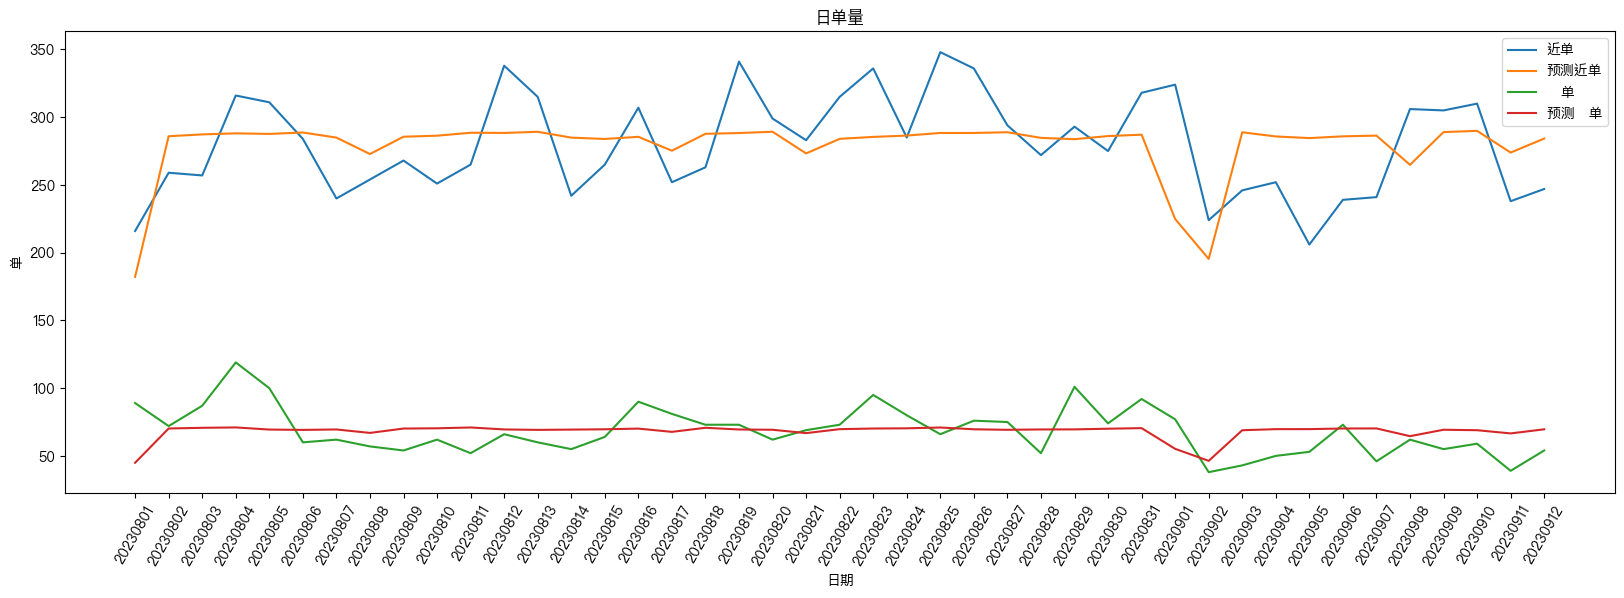

In [62]:
# 绘制折线图展示
predict_day_df['日期'] = predict_day_df['日期'].astype(str)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(predict_day_df['日期'], predict_day_df['近单'], label='近单')
ax.plot(predict_day_df['日期'], predict_day_df['预测近单'], label='预测近单')
ax.plot(predict_day_df['日期'], predict_day_df['远单'], label='远单')
ax.plot(predict_day_df['日期'], predict_day_df['预测远单'], label='预测远单')
ax.legend()
ax.set_title('日单量')
ax.set_xlabel('日期')
ax.set_ylabel('单')
plt.xticks(rotation=60)
plt.show()